In [2]:
from openfermion.hamiltonians import MolecularData, load_molecular_hamiltonian
from openfermion.ops import FermionOperator
from openfermion.transforms import bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from scipy.optimize import minimize
from pyquil import Program
from pyquil.gates import *

import numpy as np
import functools

import matplotlib.pyplot as plt
%matplotlib inline

from openfermion.utils import uccsd_generator
from forestopenfermion import exponentiate


In [2]:
sim = WavefunctionSimulator()
numQubit = 12
class Track:
    def __init__(self):
        self.cnt = 0
        
        
def solve_vqe_ucc_LiH(hamiltonian: PauliSum, degree) -> float:
    # Construct a variational quantum eigensolver solution to find the lowest
    # eigenvalue of the given hamiltonian
    
    # degree 1: up to T_1
    # degree 2: up to T_2
    
    numParams = 0
    if degree == 1:
        numParams = 16
    elif degree == 2:
        numParams = 16+64+12
    params_init = np.random.rand(numParams)*0.5-0.25
    
    track = Track()

    def inc(t, xk):
        t.cnt += 1
    
    
    def ansatz_energy(t, params):
        t.cnt += 1
        p = None
        p = Program()
        
        # Reference state
        p += X(0)
        p += X(2)
        
        single_amp = []
        double_amp = []
        
        # occupied: 0,1,2,3 unoccupied: rest
        for i in range(4):
            single_amp.append([[2*i+4, 0], params[4*i]])
            single_amp.append([[2*i+5, 1], params[4*i+1]])
            single_amp.append([[2*i+4, 2], params[4*i+2]])
            single_amp.append([[2*i+5, 3], params[4*i+3]])
            
        if degree == 2:
            for i in range(4):
                for j in range(4):
                    double_amp.append([[2*i+4, 0, 2*j+5, 1], params[16+(4*i+j)*4]])
                    double_amp.append([[2*i+4, 0, 2*j+5, 3], params[16+(4*i+j)*4+1]])
                    double_amp.append([[2*i+4, 2, 2*j+5, 1], params[16+(4*i+j)*4+2]])
                    double_amp.append([[2*i+4, 2, 2*j+5, 3], params[16+(4*i+j)*4+3]])
                    
            count = 0
            for i in range(3):
                for j in range(i+1, 4):
                    double_amp.append([[2*i+4, 0, 2*j+4, 2], params[16+64+count]])
                    count += 1
                    double_amp.append([[2*i+5, 1, 2*j+5, 3], params[16+64+count]])
                    count += 1
                    
                    
        '''
        # occupied: 0,1,2,4 unoccupied: rest
        for i in range(3):
            single_amp.append([[2*i+6, 0], params[3*i]])
            single_amp.append([[2*i+6, 2], params[3*i+1]])
            single_amp.append([[2*i+6, 4], params[3*i+2]])
        for i in range(5):
            single_amp.append([[2*i+3, 1], params[9+i]])
            
        if degree == 2:
            for i in range(4):
                for j in range(4):
                    double_amp.append([[2*i+4, 0, 2*j+5, 1], params[16+(4*i+j)*4]])
                    double_amp.append([[2*i+4, 0, 2*j+5, 3], params[16+(4*i+j)*4+1]])
                    double_amp.append([[2*i+4, 2, 2*j+5, 1], params[16+(4*i+j)*4+2]])
                    double_amp.append([[2*i+4, 2, 2*j+5, 3], params[16+(4*i+j)*4+3]])        
        '''
        
        ucc_gen = uccsd_generator(single_amp, double_amp)
        ucc_gen_qubitop = bravyi_kitaev(ucc_gen)
        try:
            ucc_program = exponentiate(ucc_gen_qubitop/(-1j))
        except:
            ucc_program = I(0)
        p += ucc_program

        energy = sim.expectation(p, hamiltonian).real
        return energy

    params_answer = minimize(functools.partial(ansatz_energy, track), params_init, method='L-BFGS-B').x
    return ansatz_energy(track, params_answer), track.cnt

In [3]:
def get_ground_energy_ucc_LiH(interaction_hamil, degree):
    fermionop_hamil = FermionOperator()
    for key in interaction_hamil:
        value = interaction_hamil[key]
        fermionop_hamil += FermionOperator(term=key, coefficient=value)
        
    qubitop_hamil = bravyi_kitaev(fermionop_hamil)
    pauliop_hamil = qubitop_to_pyquilpauli(qubitop_hamil)
    
    sim = WavefunctionSimulator()
    return solve_vqe_ucc_LiH(pauliop_hamil, degree)


In [4]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.4, 8)
vqe_ground_energies = []
vqe_iter_mean = []
vqe_iter_std = []

for degree in [1]:
    gelist = []
    iterlist = []
    for bond_length in bond_lengths:
        geometry = [('H', (0., 0., 0.)), ('Li', (0., 0., bond_length))]
        description = str(round(bond_length, 2))
        LiH_interaction_hamil = load_molecular_hamiltonian(geometry,
            basis,
            multiplicity,
            description,
            n_active_electrons=None,
            n_active_orbitals=None)

        ge, cnt = get_ground_energy_ucc_LiH(LiH_interaction_hamil, degree)
        print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge, ' iteration: ', cnt)
        gelist.append(ge)
        iterlist.append(cnt)
        
    vqe_ground_energies.append(gelist)
    vqe_iter_mean.append(np.mean(iterlist))
    vqe_iter_std.append(np.std(iterlist))


bond length:  0.3  ground state energy:  -5.848650385119788  iteration:  1123
bond length:  0.6  ground state energy:  -7.299541024614223  iteration:  511
bond length:  0.9  ground state energy:  -7.705753324726221  iteration:  375
bond length:  1.2  ground state energy:  -7.835615819547609  iteration:  409
bond length:  1.5  ground state energy:  -7.863357610043141  iteration:  409
bond length:  1.8  ground state energy:  -7.850018688323793  iteration:  409
bond length:  2.1  ground state energy:  -7.820695147349064  iteration:  579
bond length:  2.4  ground state energy:  -7.802336946862169  iteration:  443


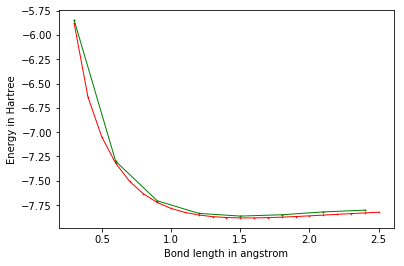

In [6]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for bond_length in np.linspace(0.3, 2.5, 23):
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
#    print(description)
    geometry = [('H', (0., 0., 0.)), ('Li', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()
    fci_energies += [molecule.fci_energy]

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'rx-', linewidth=1, markersize=1)
plt.plot(np.linspace(0.3, 2.4, 8), vqe_ground_energies[0], 'go-', linewidth=1, markersize=1)
#plt.plot(bond_lengths, vqe_ground_energies[1], 'bo-', linewidth=1, markersize=1)
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

In [7]:
print(vqe_ground_energies[0])

[-5.848650385119788, -7.299541024614223, -7.705753324726221, -7.835615819547609, -7.863357610043141, -7.850018688323793, -7.820695147349064, -7.802336946862169]


In [9]:
degree = 2

p = None
p = Program()
params = np.random.rand(92)*0.5-0.25

# Reference state
p += X(0)
p += X(2)

single_amp = []
double_amp = []

# occupied: 0,1,2,3 unoccupied: rest
for i in range(4):
    single_amp.append([[2*i+4, 0], params[4*i]])
    single_amp.append([[2*i+5, 1], params[4*i+1]])
    single_amp.append([[2*i+4, 2], params[4*i+2]])
    single_amp.append([[2*i+5, 3], params[4*i+3]])

if degree == 2:
    for i in range(4):
        for j in range(4):
            double_amp.append([[2*i+4, 0, 2*j+5, 1], params[16+(4*i+j)*4]])
            double_amp.append([[2*i+4, 0, 2*j+5, 3], params[16+(4*i+j)*4+1]])
            double_amp.append([[2*i+4, 2, 2*j+5, 1], params[16+(4*i+j)*4+2]])
            double_amp.append([[2*i+4, 2, 2*j+5, 3], params[16+(4*i+j)*4+3]])

    count = 0
    for i in range(3):
        for j in range(i+1, 4):
            double_amp.append([[2*i+4, 0, 2*j+4, 2], params[16+64+count]])
            count += 1
            double_amp.append([[2*i+5, 1, 2*j+5, 3], params[16+64+count]])
            count += 1


ucc_gen = uccsd_generator(single_amp, double_amp)
ucc_gen_qubitop = bravyi_kitaev(ucc_gen)
try:
    ucc_program = exponentiate(ucc_gen_qubitop/(-1j))
except:
    ucc_program = I(0)
p += ucc_program

print(len(p))

13174


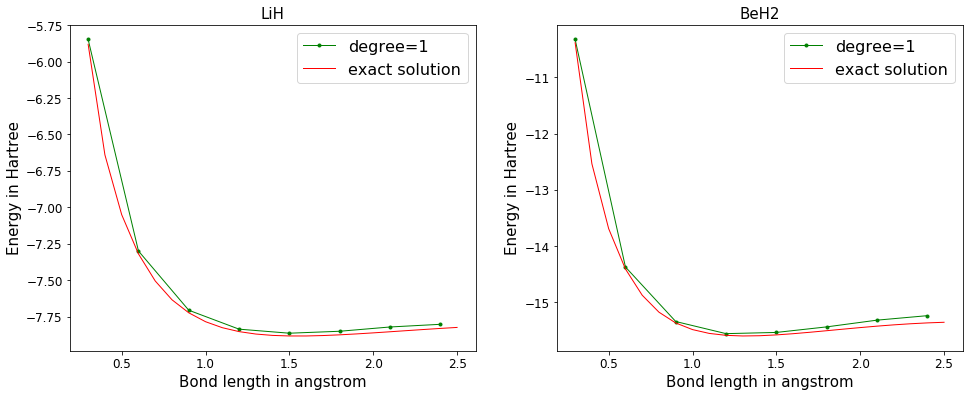

In [17]:
LiH_energies = [-5.848650385119788, -7.299541024614223, -7.705753324726221, -7.835615819547609, -7.863357610043141, -7.850018688323793, -7.820695147349064, -7.802336946862169]
BeH2_energies = [-10.330012617652656, -14.370075461352055, -15.338455474796321, -15.553586412736964, -15.532213318694374, -15.433625855632673, -15.314113243996117, -15.234590028212425]
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1

# Generate molecule at different bond lengths.
fci_energies1 = []
fci_energies2 =[]
bond_lengths = []
for bond_length in np.linspace(0.3, 2.5, 23):
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
#    print(description)
    geometry = [('H', (0., 0., 0.)), ('Li', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()
    fci_energies1 += [molecule.fci_energy]
    
    geometry = [('H', (0., 0., -bond_length)), ('Be', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()
    fci_energies2 += [molecule.fci_energy]

fci_energies2[4] = -14.871329756203133   


f = plt.figure(figsize=(16,6))
ax = f.add_subplot(121)
ax.plot(np.linspace(0.3, 2.4, 8), LiH_energies, 'go-', linewidth=1, markersize=3, label='degree=1')
ax.plot(bond_lengths, fci_energies1, 'r-', linewidth=1, markersize=1, label='exact solution')
ax.tick_params(labelsize = 12)
ax.set_title('LiH', fontsize=15)
plt.legend(prop={'size': 16})
plt.ylabel('Energy in Hartree', size=15)
plt.xlabel('Bond length in angstrom', size=15)

ax2 = f.add_subplot(122)
ax2.plot(np.linspace(0.3, 2.4, 8), BeH2_energies, 'go-', linewidth=1, markersize=3, label='degree=1')
ax2.plot(bond_lengths, fci_energies2, 'r-', linewidth=1, markersize=1, label='exact solution')
ax2.tick_params(labelsize = 12)
ax2.set_title('BeH2', fontsize=15)
plt.ylabel('Energy in Hartree', size=15)
plt.legend(prop={'size': 16})
plt.xlabel('Bond length in angstrom', size=15)
f.savefig('PLOT4.pdf', bbox_inches='tight')


In [22]:
fci_energies1_reduced = []
fci_energies2_reduced = []
for i in range(8):
    fci_energies1_reduced.append(fci_energies1[3*i])
    fci_energies2_reduced.append(fci_energies2[3*i])
fci_energies1_reduced = np.array(fci_energies1_reduced)
fci_energies2_reduced = np.array(fci_energies2_reduced)
print(np.mean(1-np.abs((LiH_energies-fci_energies1_reduced)/fci_energies1_reduced)))
print(np.mean(1-np.abs((BeH2_energies-fci_energies2_reduced)/fci_energies2_reduced)))

0.9967407600517272
0.9957426647597392
